# Statistical Data Analysis #

This notebook aims to complete the following tasks:
* Compute mean and median length of reviews for each star rating, and compute whether the differences in the means and medians are statistically significant.
* Identify some number of frequent words across each star rating, calculate their frequency for each star rating, compare the differences of frequency across star ratings, and compute whether the differences in frequency are statistically significant.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import data as DataFrame
reviews = pd.read_csv('/Users/dwalkerpage/Documents/Data_Science/Springboard/Projects/springboard/Capstone_Projects/Capstone_Project_1/Capstone_Project_1_Data/restaurant_reviews_final.csv')

## Analysis of Differences in Mean Review Length for Each Star Rating ##

**Null Hypothesis:** The mean and median review lengths are the same for each star rating.  
**Alternative Hypothesis:** The mean and median review lengths are *not* the same for each star rating.  
We can perform a permutation test of the null hypothesis.

In [5]:
# Construct series of review lengths (measured in terms of number of characters in review)
review_lens = reviews['text'].str.len()

In [6]:
# Construct new DataFrame with review lengths added as a column
review_lens_df = reviews.copy()
review_lens_df['review_lengths'] = review_lens
#review_lens_df.head()

In [7]:
review_lens_df.head()

,business_id,stars,text,review_lengths
0,EXAbfr5PkoRzMqlCb_3ALQ,5.0,We were in town from San Francisco to visit fr...,823
1,6sOBPz69VLgIvNAY7dowOg,2.0,I bought a Dealfind voucher and decided to giv...,534
2,VMXl3Dm1Nwvgwo1PVYTXbg,5.0,Fun club!! Great place to hang out and a real...,124
3,yNPh5SO-7wr8HPpVCDPbXQ,5.0,After our horrible customer service next door ...,353
4,L0aSDVHNXCl6sY4cfZQ-5Q,1.0,"If I could give this place zero stars, I would...",499


In [8]:
# Compute mean and median length of reviews for each star rating
len_stats = review_lens_df.groupby('stars').agg([np.mean, np.median])
len_stats

review_lengths       
                mean median
stars                      
1.0       669.122246    479
2.0       734.363719    551
3.0       701.818360    533
4.0       615.932487    449
5.0       469.145701    320

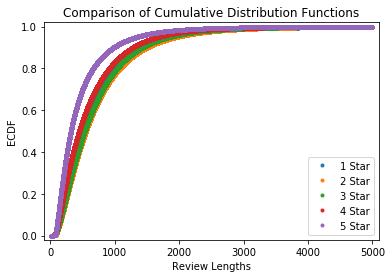

In [9]:
# Plot empirical cumulative distribution functions of review lengths for each star rating
# The ECDF indicates the distributions of the review lengths for each star rating,
# and how these relate to each other
x1 = np.sort(review_lens_df[review_lens_df['stars'] == 1.0]['review_lengths'])
x2 = np.sort(review_lens_df[review_lens_df['stars'] == 2.0]['review_lengths'])
x3 = np.sort(review_lens_df[review_lens_df['stars'] == 3.0]['review_lengths'])
x4 = np.sort(review_lens_df[review_lens_df['stars'] == 4.0]['review_lengths'])
x5 = np.sort(review_lens_df[review_lens_df['stars'] == 5.0]['review_lengths'])
y1 = np.arange(1, len(x1)+1) / len(x1)
y2 = np.arange(1, len(x2)+1) / len(x2)
y3 = np.arange(1, len(x3)+1) / len(x3)
y4 = np.arange(1, len(x4)+1) / len(x4)
y5 = np.arange(1, len(x5)+1) / len(x5)

_ = plt.plot(x1, y1, marker='.', linestyle='none', label='1 Star')
_ = plt.plot(x2, y2, marker='.', linestyle='none', label='2 Star')
_ = plt.plot(x3, y3, marker='.', linestyle='none', label='3 Star')
_ = plt.plot(x4, y4, marker='.', linestyle='none', label='4 Star')
_ = plt.plot(x5, y5, marker='.', linestyle='none', label='5 Star')
_ = plt.xlabel('Review Lengths')
_ = plt.ylabel('ECDF')
_ = plt.title('Comparison of Cumulative Distribution Functions')
plt.margins(0.02)
plt.legend(loc='lower right')
plt.show()

#### Some options for proceeding: ####
1. Use a standard statistical test (such as z-test or t-test) and compute confidence intervals and p-values
2. Use bootstrap method to approximate population distribution and compute confidence intervals and p-values
3. Use bootstrap method and permutation

#### I will use the second option. To accomplish this hypothesis testing, I will execute the following steps: ####
1. Define function to calculate test statistic (difference between means, difference between medians)
2. Calculate observed statistics
3. Define function to draw samples of size 1000, then draw bootstrap samples from the samples, and then compute replicate statistics on the bootstrap samples
4. Execute function 1000 times to calculate 1000 replicate statistics and store them in array
5. Calculate 95% confidence interval
6. Plot the distribution of replicates as a histogram, and plot 95% confidence interval
7. Calculate p-value, and see if it is statistically significant (i.e. less than or equal to 0.05).

### Step 1:

In [22]:
# Define function to calculate test statistics,
# which will be the difference between certain summary statistics (e.g. mean, median)
def difference(data1, data2, func):
    return abs(func(data1) - func(data2))

### Step 2:

In [25]:
# Calculate observed statistics between one star review lengths and five star review lengths
one_star_lens = review_lens_df[review_lens_df['stars'] == 1.0]['review_lengths']
five_star_lens = review_lens_df[review_lens_df['stars'] == 5.0]['review_lengths']

one_five_mean_difference = difference(one_star_lens, five_star_lens, np.mean)
one_five_median_difference = difference(one_star_lens, five_star_lens, np.median)

print('Observed Difference Between Means: ', one_five_mean_difference)
print('Observed Difference Between Medians: ', one_five_median_difference)

Observed Difference Between Means:  199.97654537970624
Observed Difference Between Medians:  159.0


### Step 3:

In [26]:
# Define function to (1) draw samples, (2) draw bootstrap samples, and (3) compute replicate statistics
np.random.seed(7)

def bootstrap_replicates(data1, data2, func):
    # Draw samples of size 1000 from data
    data1_sample = data1.sample(n=1000, random_state=7)
    data2_sample = data2.sample(n=1000, random_state=7)
    
    # Construct bootstrap samples
    # To do this, sample (with replacement) from original sample data
    # Make sample the same size as the original sample
    bs_sample1 = np.random.choice(data1_sample, len(data1_sample))
    bs_sample2 = np.random.choice(data2_sample, len(data2_sample))
    
    # Calculate replicate statistic
    bs_replicate = difference(bs_sample1, bs_sample2, func)
    
    return bs_replicate

### Step 4:

In [31]:
%%time

# Calculate 1000 replicates

# Construct empty arrays to store replicates
mean_difference_bs_replicates = np.empty(1000)
median_difference_bs_replicates = np.empty(1000)

for i in range(1000):
    mean_difference_bs_replicates[i] = bootstrap_replicates(one_star_lens, five_star_lens, np.mean)
    median_difference_bs_replicates[i] = bootstrap_replicates(one_star_lens, five_star_lens, np.median)

CPU times: user 1min 52s, sys: 7.74 s, total: 2min
Wall time: 2min


### Step 5:

In [52]:
# Compute 95% confidence intervals
mean_confidence_interval = np.percentile(mean_difference_bs_replicates, [2.5, 97.5])
median_confidence_interval = np.percentile(median_difference_bs_replicates, [2.5, 97.5])

print('Confidence Interval for Difference Between Means: [{}, {}]'.format(mean_confidence_interval[0], mean_confidence_interval[1]))
print('Confidence Interval for Difference Between Medians: [{}, {}]'.format(median_confidence_interval[0], median_confidence_interval[1]))

Confidence Interval for Difference Between Means: [151.97242499999996, 242.36042500000002]
Confidence Interval for Difference Between Medians: [131.5, 213.0125]


### Step 6:

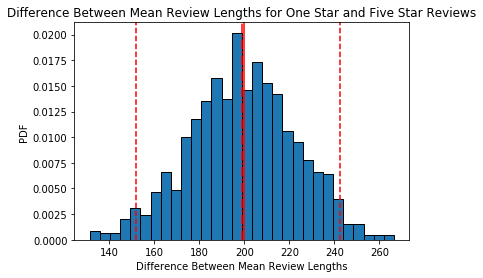

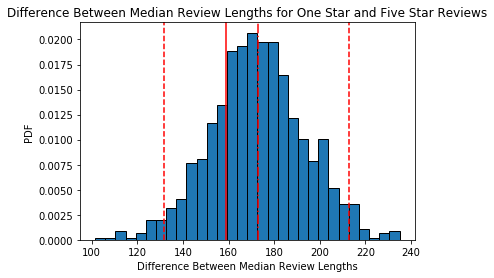

In [56]:
_ = plt.hist(mean_difference_bs_replicates, bins=30, density=True, ec='black')
_ = plt.xlabel('Difference Between Mean Review Lengths')
_ = plt.ylabel('PDF')
_ = plt.title('Difference Between Mean Review Lengths for One Star and Five Star Reviews')
_ = plt.axvline(mean_confidence_interval[0], color='r', linestyle='--')
_ = plt.axvline(mean_confidence_interval[1], color='r', linestyle='--')
_ = plt.axvline(np.mean(mean_difference_bs_replicates), color='r', linestyle='-.')
_ = plt.axvline(one_five_mean_difference, color='r', linestyle='-')


plt.show()

_ = plt.hist(median_difference_bs_replicates, bins=30, density=True, ec='black')
_ = plt.xlabel('Difference Between Median Review Lengths')
_ = plt.ylabel('PDF')
_ = plt.title('Difference Between Median Review Lengths for One Star and Five Star Reviews')
_ = plt.axvline(median_confidence_interval[0], color='r', linestyle='--')
_ = plt.axvline(median_confidence_interval[1], color='r', linestyle='--')
_ = plt.axvline(np.mean(median_difference_bs_replicates), color='r', linestyle='-.')
_ = plt.axvline(one_five_median_difference, color='r', linestyle='-')

plt.show()

### Step 7:

In [61]:
# Calculate p-values

In [60]:
# Thoughts on p-value

# p_value_mean_differences = np.sum(mean_difference_bs_replicates != one_five_mean_difference) / 1000

# p_value_median_differences = np.sum(median_difference_bs_replicates != one_five_median_difference) / 1000

# print(p_value_mean_differences)
# print(p_value_median_differences)

In [10]:
# # Define ss_between function to compute test statistic
# def ss_between(group, overall_data=review_lens_df['review_lengths']):
#     return len(group) * (np.mean(group) - np.mean(overall_data))**2

In [54]:
# ss_between(review_lens_df[review_lens_df['stars'] == 1.0]['review_lengths']) + ss_between(review_lens_df[review_lens_df['stars'] == 2.0]['review_lengths']) + ss_between(review_lens_df[review_lens_df['stars'] == 3.0]['review_lengths']) + ss_between(review_lens_df[review_lens_df['stars'] == 4.0]['review_lengths']) + ss_between(review_lens_df[review_lens_df['stars'] == 5.0]['review_lengths'])

## Analysis of Differences in Word Frequency ##

Suggestions for calculating word frequencies:
* https://stackoverflow.com/questions/46786211/counting-the-frequency-of-words-in-a-pandas-data-frame
* https://www.geeksforgeeks.org/find-frequency-of-each-word-in-a-string-in-python/
* https://www.datacamp.com/community/tutorials/absolute-weighted-word-frequency
* https://programminghistorian.org/en/lessons/counting-frequencies
* *Think Python*, Ch. 13